# Implementando os Modelos Simples e Convolucional

In [ ]:
# Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%tensorflow_version 1.x
%matplotlib inline

# GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Keras
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

# Bibliotecas de ajuda
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

from __future__ import print_function, division


from PIL import Image 
import glob
import cv2

from datetime import datetime, date, time

import sys

Found GPU at: /device:GPU:0


Using TensorFlow backend.


## Importando o conjunto de dados
Agora precisamos importar o conjunto de imagens (Dados Reais) e guardá-lo em um Array (vetor/matriz) para podermos preprocessá-las.

In [ ]:
# Linhas e Colunas de pixels
row = 78
col = 108

# Contador
cont = 0

# Imagens das partituras
part_tr = []

for arquivo in glob.glob('/content/gdrive/My Drive/IC/SatsGAN/satsResized/*.png'):  
    im = cv2.imread(arquivo, cv2.IMREAD_COLOR)
#    part_tr.append(im)
#    cont += 1
    if im.shape[0] == row and im.shape[1] == col:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        part_tr.append(im)
    cont += 1

In [ ]:
np.array(part_tr).shape

(732, 78, 108, 3)

## Preprocessamento
Nessa etapa, nós vamos normalizar as imagens, para que os pixels, na escala de cinza, estejam todos no intervalo de [-1, 1], para facilitar a manipulação delas mais a frente, com as Redes.


In [ ]:
X_tr = np.array(part_tr)

X_tr = X_tr / 127.5 - 1.

print(X_tr.shape)

(732, 78, 108, 3)


## Dimensões

In [ ]:
img_rows = row
img_cols = col
channels = 3

img_shape = (img_rows, img_cols, channels)

# Tamanho do vetor de ruído
z_dim = 100

X_train = X_tr
print(X_train.shape, [img_rows, img_cols])

(732, 78, 108, 3) [78, 108]


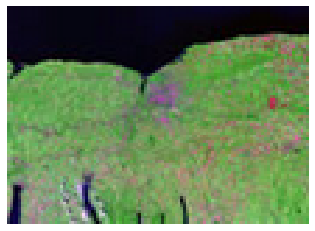

In [ ]:
plt.axis('off')
plt.imshow(part_tr[545])

## GAN Simples

### Gerador

In [ ]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    
    # Fully connected layer
    model.add(Dense(256, input_dim=z_dim))
    
    # Activation
    model.add(LeakyReLU(alpha=0.2))
    
    # Normalization
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    # Output layer
    model.add(Dense(img_rows * img_cols * channels, activation='tanh'))
    
    # Reshape the generator output to image dimensions
    model.add(Reshape(img_shape))

    model.summary()
    
    return model

### Discriminador

In [ ]:
def build_discriminator(img_shape):
    model = Sequential()
    
    # input image
    model.add(Flatten(input_shape=img_shape))
    
    model.add(Dense(256))
    
    # Activation
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    
    return model

### Construir e Compilar o Modelo

In [ ]:
def build_gan(generator, discriminator):
    
    model = Sequential()
    
    # Combined Generator <-> Discriminator
    model.add(generator)
    model.add(discriminator)
    
    return model

In [ ]:
# Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Generator
generator = build_generator(img_shape, z_dim)

# Keeps discriminator's parameters constant for generator training
discriminator.trainable = False

# Build and compile
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 25272)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               6469888   
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 64)               

### Treinamento

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iteractions, batch_size, sample_interval):
    # Labels for real images
    real = np.ones((batch_size, 1))
    
    # Labels for fake images
    fake = np.zeros((batch_size, 1))
    
    # Get time
    print('Start training...')
    start_training = datetime.now()
    
    for iteration in range(iteractions):
        # Train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train the generator
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0 or iteration == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            now = datetime.now()
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            print(f'Elapsed time: {now - start_training} - {now}')
            
            # Output a generated image sample
            sample_images(generator, iteration)

    now = datetime.now()
    print(f'Total elapsed time: {now - start_training} - {now}')

### Display das Imagens

In [ ]:
def sample_images(generator, iteration, image_grid_rows=4, image_grid_cols=4):
    # Random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_cols, z_dim))
    
    gen_imgs = generator.predict(z)
    
    # Rescale values to 0, 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_cols,
                           figsize=(4, 4),
                           sharey=True,
                           sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_cols):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0])
            axs[i, j].axis('off')
            cnt += 1
        fig.savefig("/content/gdrive/My Drive/IC/SatsGAN/rgbResult/%d.png" % iteration)

### Rodar o Modelo

In [ ]:
iteractions = 5000
batch_size = 128
sample_interval = 500

# Train the GAN
train(iteractions, batch_size, sample_interval)

### Funções de Custo

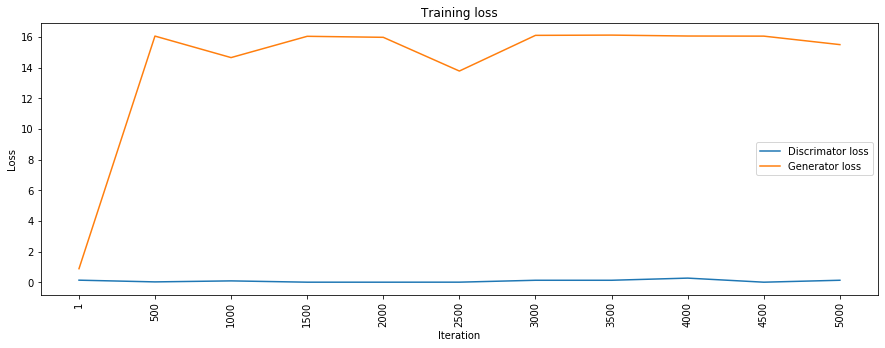

In [ ]:
losses = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discrimator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

### Acurácia

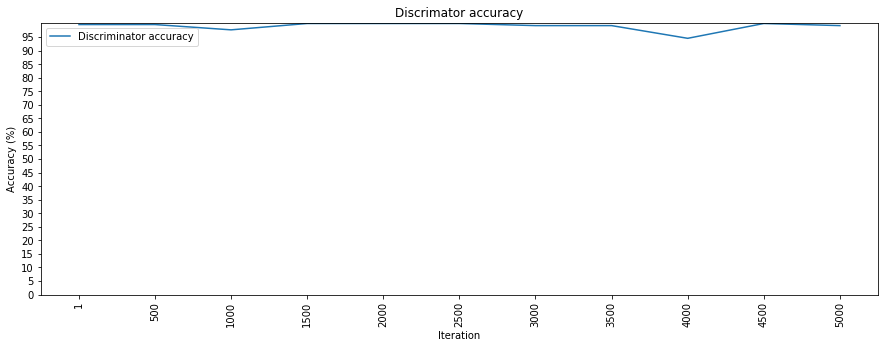

In [ ]:
accuracies = np.array(accuracies)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label='Discriminator accuracy')
plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title('Discrimator accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.legend()

## GAN Convolucional

### Gerador

In [ ]:
def build_generator(z_dim):
    model = Sequential()
    
    model.add(Dense(256*13*18, input_dim=z_dim))
    model.add(Reshape((13,18,256)))
    
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    ''''''
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(3, kernel_size=3, strides=3, padding='same'))
    
    model.add(Activation('tanh'))
    
    return model

### Discriminador

In [ ]:
def build_discriminator(img_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

### Construir e Compilar o Modelo

In [ ]:
def build_gan(generator, discriminator):
    model = Sequential()
    
    model.add(generator)
    model.add(discriminator)
    
    return model

In [ ]:
# Build and compile the discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Build the generator
generator = build_generator(z_dim)

discriminator.trainable = False

# Build and compile the gan
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
idx = np.random.randint(0, X_train.shape[0], 128)
imgs = X_train[idx]
z = np.random.normal(0, 1, (128, z_dim))
gen_imgs = generator.predict(z)
print(gen_imgs.shape)

(128, 78, 108, 3)


### Treinamento

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    # Labels for real and fake images
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    print('Start training...')
    training_start_time = datetime.now()
    for iteration in range(iterations):
        # Get a random sample from training dataset
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        # Create the random input to train the discriminator
        z = np.random.normal(0, 1, (batch_size, z_dim))
        # and passes to the generator
        gen_imgs = generator.predict(z)
        
        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Create new random input for the generator
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
        
        # Train the generator
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0 or iteration == 0:
            now = datetime.now()
            print(f'Elapsed time since start: {now - training_start_time} - {now}')
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            print(f"{iteration+1} [D loss: {d_loss}, acc: {100.0 * accuracy}%] [G loss]: {g_loss}")
            sample_images(generator, iteration)

    now = datetime.now()
    print(f'Total training time: {now - training_start_time} - {now}')

### Display das Imagens

In [ ]:
def sample_images(generator, iteration, image_grid_rows=4, image_grid_cols=4):
    # Random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_cols, z_dim))
    
    gen_imgs = generator.predict(z)
    
    # Rescale values to 0, 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_cols,
                           figsize=(4, 4),
                           sharey=True,
                           sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_cols):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0])
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("/content/gdrive/My Drive/IC/SatsGAN/rgbResult/%d.png" % iteration)

### Rodar o Modelo

In [ ]:
iterations = 50000
batch_size = 128
sample_interval = 1000

In [ ]:
train(iterations, batch_size, sample_interval)

### Funções de Custo

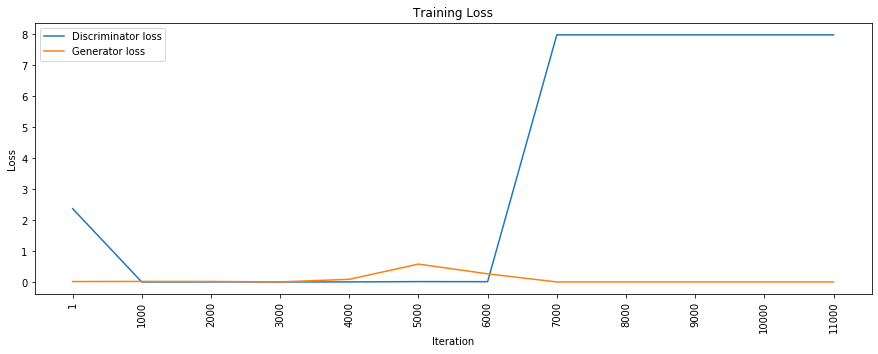

In [ ]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
#plt.style.use('dark_background')
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

### Acurácia

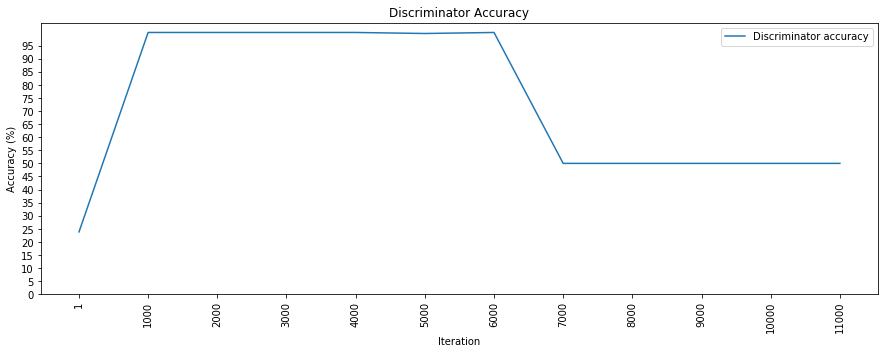

In [ ]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()